In [1]:
import sys
sys.path.append('/Volumes/yyx_DISK/despotic')
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.colors import LogNorm
from scipy.optimize import brentq
import matplotlib.cm as cm
import matplotlib.colors as colors
from despotic import emitter
from despotic.winds import pwind, zetaM, sxMach
from astropy.io import fits
# Constants; switch to cgs
from scipy.constants import G, c, m_p, m_e, h
from scipy.constants import k as kB
from astropy.units import Msun, yr, Angstrom, pc
# interact
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import emcee

sys.path.append('/Volumes/yyx_DISK/mcmc_code')
import wind_obs_diag_pkg as wodp
import wind_obs_diag_pkg_interact as wodpi

# directory of data
dat_dir = 'wind_data'

#import yt
c = 1e2*c
hP = h*1e7
G = 1e3*G
kB = 1e7*kB
mH = (m_e + m_p)*1e3
muH = 1.4
Msun = Msun.to('g')
yr = yr.to('s')
Myr = 1e6*yr
Gyr = 1e9*yr
ang = Angstrom.to('cm')
pc = pc.to('cm')
kpc = 1e3*pc
# Fiducial parameters
mdotstar = 4.1*Msun/yr
epsff = 0.01
mach = 100.0
uh = 10.0
v0 = 120e5*np.sqrt(2)
r0 = 250*pc
m0 = v0**2*r0/(2.0*G)
rho0 = 3.0*m0/(4.0*np.pi*r0**3)
tc = r0/v0
temp = 50.
dist = 3.5e3*kpc

In [2]:
# emission line data
obj = 'M82'
#3.6Mpc (Freedman et al. 1994) so that 1''=17.5 pc and 1'=1 kpc
# systematic velocity 211 km/s 

# emission  Warm ionized gas
# Ha Martin98 
# north pos_a~1kpc
print('Halpha')
Ha = fits.open('%s/%s/Martin98/NGC_3034_I_Ha_d2009.fits'%(dat_dir, obj))

l_n, Ha_n = np.loadtxt('%s/%s/Martin98/M82_north.txt'%(dat_dir, obj), usecols=(0,1), unpack=True, skiprows=1)
Ha_n_e = np.loadtxt('%s/%s/Martin98/M82_north_rms.txt'%(dat_dir, obj), usecols=(1), unpack=True,skiprows=1)
l_s, Ha_s = np.loadtxt('%s/%s/Martin98/M82_south.txt'%(dat_dir, obj), usecols=(0,1), unpack=True,skiprows=1)
Ha_s_e = np.loadtxt('%s/%s/Martin98/M82_south_rms.txt'%(dat_dir, obj), usecols=(1), unpack=True,skiprows=1)
v_n = (l_n/6562.801-1)*c/1.e5
v_s = (l_s/6562.801-1)*c/1.e5


# infomation on the data

# 0.43'' (0.43''*17.5pc = 7.525 pc)
print('Halpha')
print(Ha.info(),'\n')
print([Ha[0].header])
print(Ha[0].__dict__.keys(),'\n\n')
Ha = Ha[0].data

Halpha
Halpha
Filename: wind_data/M82/Martin98/NGC_3034_I_Ha_d2009.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (679, 681)   float32   
None 

[SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  679 / Axis length                                    
NAXIS2  =                  681 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '14:29:18 (09/12/2009)'                                               
OBJECT  = 'M82 653 '           /                                                
DATE    = '2008-02-05T20:21:43'                                

In [3]:
# total luminosity
import astropy.constants as c; import astropy.units as u; 

area = (0.43/3600.*np.pi/180.)**2 # in rad**2
area_pix = (0.43*17.5*u.pc)**2
area_tot = 679*681*area_pix 

print('area of pixel in rad^2: %e rad'%area)

flux = 10**(-10.0915)*u.erg/u.s/u.cm**2

# total luminosity
D = 3.6*u.Mpc
L = flux*D**2*4*np.pi
L = L.to(u.erg/u.s)
logL = np.log10(L.value)
print('logrithmic of Luminosity of source in erg/s: %f'%logL)

area of pixel in rad^2: 4.345969e-12 rad
logrithmic of Luminosity of source in erg/s: 41.099016


### surface brightness
$$
SB_{\rm pix} = \frac{L_{\rm tot} }{A_{\rm pix}} \frac{counts_{\rm pix}}{counts_{\rm tot}} = \frac{4 \pi F_{\rm tot} }{ [0.43'' \mathrm{in \space rad}]^2 } \frac{counts_{\rm pix}}{counts_{\rm tot}}
$$

$$ c_\rho = \frac{\langle n^2 \rangle}{\langle n\rangle^2}$$

$$ \mathrm{SB} = \frac{ \alpha_{\rm H\alpha} e_{\rm H\alpha} D_{\rm LOS} \langle n^2 \rangle }{c_\rho} = \alpha_{\rm H\alpha} e_{\rm H\alpha} D_{\rm LOS} \langle n \rangle ^2 $$

$$ c_\rho = \frac{ \alpha_{\rm H\alpha} e_{\rm H\alpha} D_{\rm LOS} \langle n^2 \rangle }{ \mathrm{SB} }$$

In [4]:
lam = 4681.*u.Angstrom
e = c.h*c.c/lam
print( e.to(u.erg) )# Halpha energy

# in cgs
alpha_ha = 4e-13
e_ha = 3.03e-12 
SB = 4*np.pi*5.04e-4 # in erg/s/cm^2
D = 1*kpc
n_rms = 4 # root mean square density
c_rho = ( SB/alpha_ha/e_ha/D/n_rms**2 )**-1
print('clumping factor %f'%c_rho)

4.243635670046845e-12 erg
clumping factor 9.447845


In [5]:
# mean density
n_m = np.sqrt(SB/alpha_ha/e_ha/D)
n_m

1.3013485056468923

In [6]:
sp_r = 5
n_g = int( sp_r*1000/(0.4347*17.5) )
Ha_rot= wodp.rotate_2d(Ha, center=(325,345), angle=-23, n_g=n_g )

In [7]:
#surface brightness
tot_count = np.sum(Ha)
tot_count
thres = np.max(Ha)/100
np.sum(Ha[Ha>thres])/tot_count

n_kpc = int(1000./7.525)
# total flux 10**(-10.0915) ergs/s/cm^2
norm = 10.**(-10.0915)/23962321.5
#area = (0.43/3600.*np.pi/180.)**2 # in rad^2 = Sr
area = 0.43**2 # in arcsec^2 
SB_n = norm*Ha_rot[180, 180+n_kpc]/area/1.3 # in erg/s/cm^2
SB_s = norm*Ha_rot[180, 180-n_kpc]/area/1.3

print(SB_n)
print(SB_n)

2.6685547818997584e-15
2.6685547818997584e-15


center RA 09:55:52.2 Dec 69:40:47
north RA 09:55:47.6 Dec 69:41:43
south RA 09:55:57.8 Dec 69:39:33

<ipython-input-8-f226ca377170>:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(norm*Ha/area/1.3, norm=LogNorm(), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],


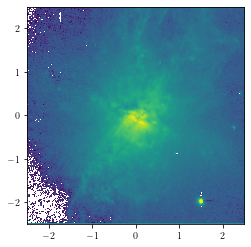

In [8]:

plt.imshow(norm*Ha/area/1.3, norm=LogNorm(), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],
           vmin=1e-17, vmax=5e-13)

In [9]:
def rotate_2d(pp, center, angle, n_g):
    # rotate the spatial part of the ppv cube and zoom in
    # note that n_g should be even
    (x0, y0) = center
    pp_rot = np.zeros((n_g, n_g))
    nx, ny = np.shape(pp)
    
    if angle == 0:
      pp_rot = pp[int(x0-n_g/2):int(x0+n_g/2),
                  int(y0-n_g/2):int(y0+n_g/2)]
    elif angle != 0:
      c = np.cos(angle*np.pi/180.)
      s = np.sin(angle*np.pi/180.)
      for x in range(n_g):
        for y in range(n_g):
          src_x = int( c*(x-n_g/2) + s*(y-n_g/2) + x0 )
          src_y = int( -s*(x-n_g/2) + c*(y-n_g/2) + y0 )
          if 0<=src_x<nx and 0<src_y<ny:
            pp_rot[x, y] = pp[int(src_x), int(src_y)]
          else:
            pp_rot[x, y] = -1
    return pp_rot

Distance between two sites from which spectra are extracted.

130 arcsec/cos(23 degree)*17.5/1000

In [12]:
130/np.cos(23*np.pi/180)*17.5/1000

2.4714698585970485

<ipython-input-13-ec0af2b24784>:6: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(norm*Ha_rot/area/1.3, norm=LogNorm(), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],


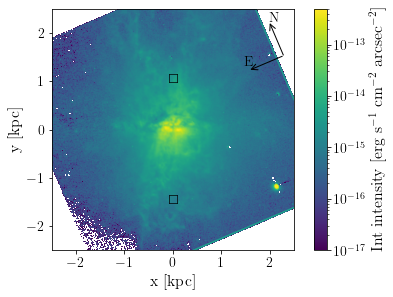

In [13]:
sp_r = 0.4347*17.5*n_g/1000 # in kpc

# in erg/s/cm^2/arcsec^2

plt.rcParams.update({'font.size': 14})
plt.imshow(norm*Ha_rot/area/1.3, norm=LogNorm(), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],
           vmin=1e-17, vmax=5e-13)
cb = plt.colorbar()

pt_ha = [0,0]
pa_ha = [1.06, -1.43]
w_a = 0.16
for p_t, p_a in zip(pt_ha, pa_ha):
    l_e = p_t-w_a/2; r_e = p_t+w_a/2; u_e = p_a+w_a/2; d_e = p_a-w_a/2 
    plt.plot(np.linspace(l_e, r_e, 10), [u_e]*10, c='k', linewidth=0.7)
    plt.plot(np.linspace(l_e, r_e, 10), [d_e]*10, c='k', linewidth=0.7)
    plt.plot([l_e]*10, np.linspace(d_e, u_e, 10), c='k', linewidth=0.7)
    plt.plot([r_e]*10, np.linspace(d_e, u_e, 10), c='k', linewidth=0.7)

plt.xlabel('x [kpc]',fontsize=16)
plt.ylabel('y [kpc]',fontsize=16)
cb.set_label(r'Int intensity [erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]',size=16)

angle = 23/180*np.pi
plt.annotate('', xy=(2.3, 1.5),  xycoords='data',
            xytext=(2.3-0.8*np.sin(angle), 1.5+0.8*np.cos(angle) ), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle="<-",connectionstyle="arc3"),
            horizontalalignment='right', verticalalignment='top',size=15,
            )

plt.annotate('', xy=(2.3, 1.53),  xycoords='data',
            xytext=(2.3-0.8*np.cos(angle), 1.53-0.8*np.sin(angle)), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle="<-",connectionstyle="arc3"),
            horizontalalignment='right', verticalalignment='top',size=15,
            )

plt.text(2.3-0.8*np.sin(angle), 1.5+0.8*np.cos(angle), 'N')
plt.text(2.2-0.8*np.cos(angle), 1.63-0.8*np.sin(angle), 'E')


plt.subplots_adjust(hspace=0, wspace=0, left=0.0, top=0.99, bottom=0.15, right=0.96)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.savefig('figure/Halpha_map.pdf')


In [55]:
1.58/0.71

2.2253521126760565

### H$\alpha$ spectra

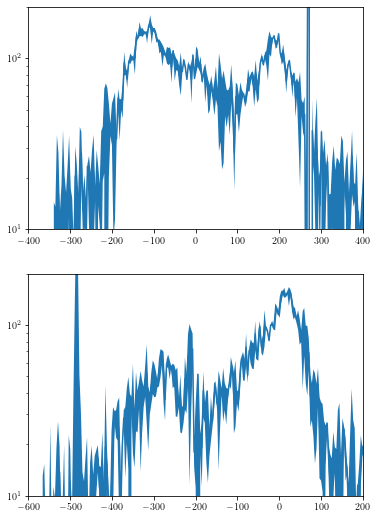

In [11]:
fig, axs = plt.subplots(2,1, figsize=(6, 9))
axs[0].semilogy(v_n-211, Ha_n)
axs[0].fill_between(v_n-211, Ha_n-np.abs(Ha_n_e), Ha_n+np.abs(Ha_n_e))
axs[0].axis([-400,400,1e1,2e2])
axs[1].semilogy(v_s-211, Ha_s)
axs[1].fill_between(v_s-211, Ha_s-np.abs(Ha_s_e), Ha_s+np.abs(Ha_s_e))
axs[1].axis([-600,200,1e1,2e2])
plt.savefig('Halpha_spct.png')